In [28]:
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/home/student/.conda/envs/hw2_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


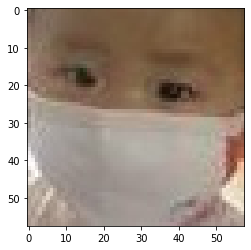

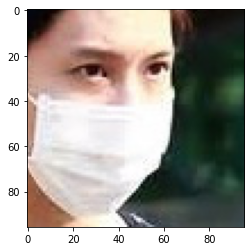

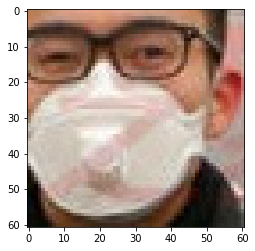

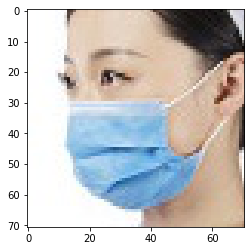

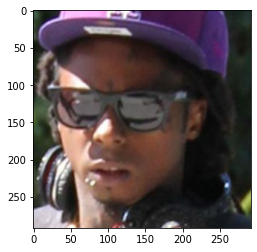

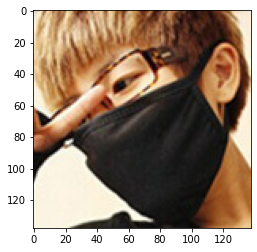

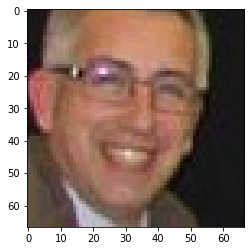

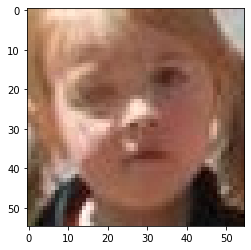

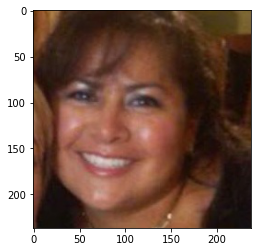

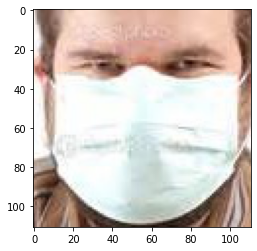

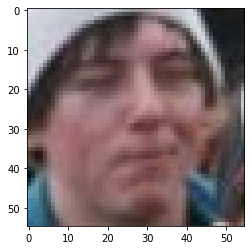

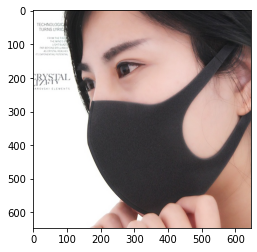

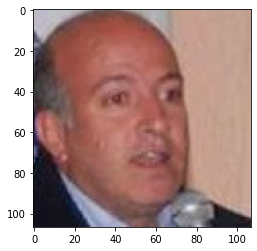

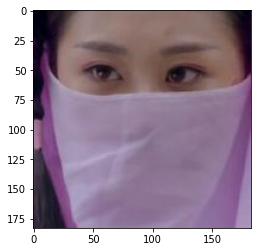

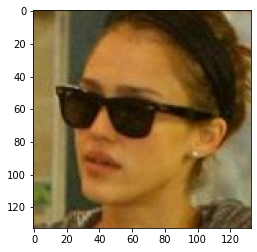

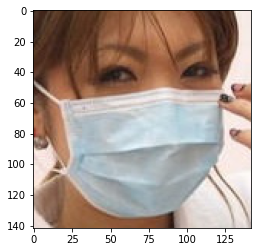

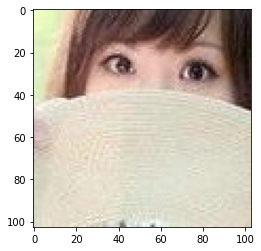

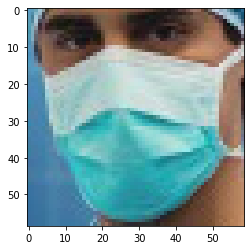

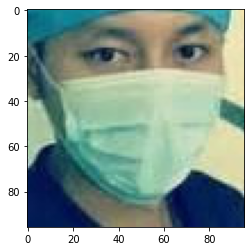

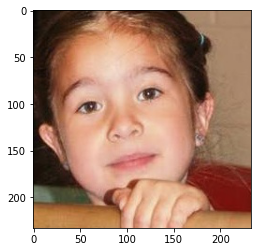

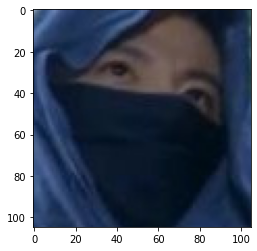

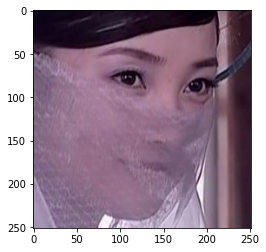

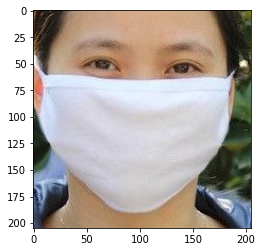

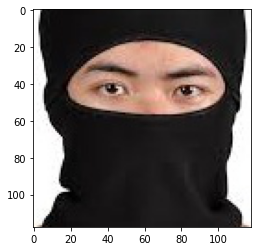

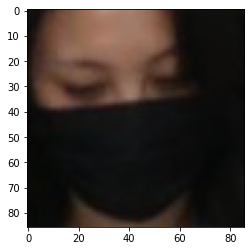

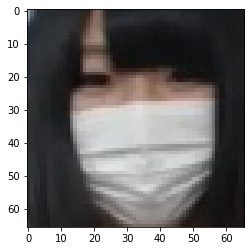

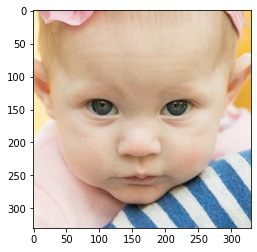

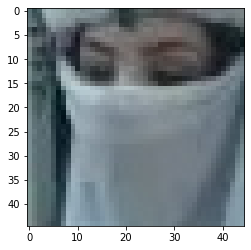

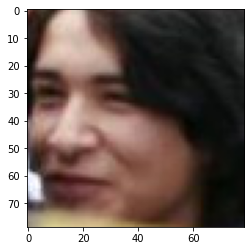

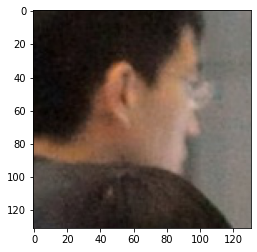

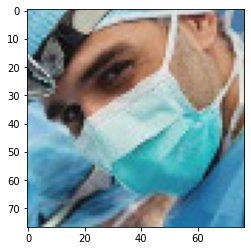

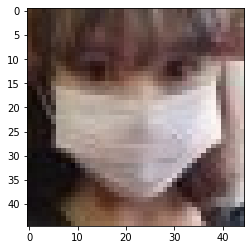

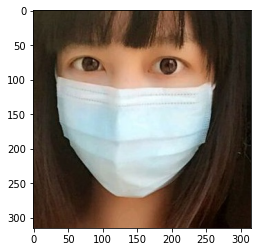

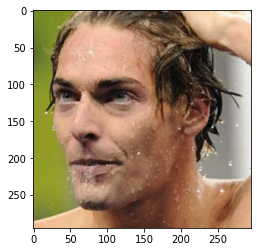

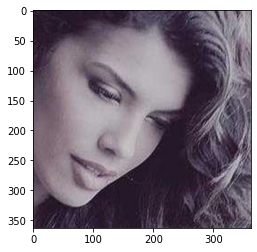

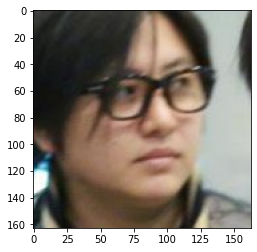

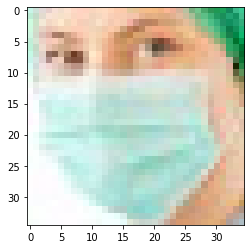

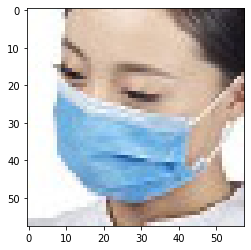

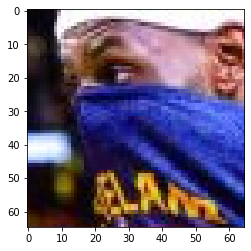

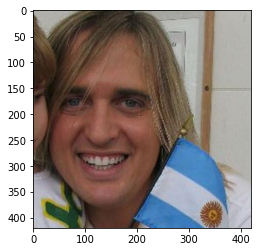

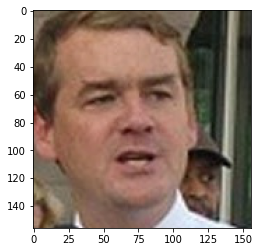

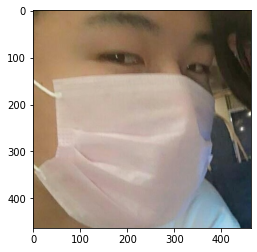

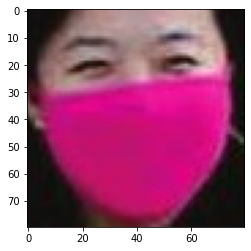

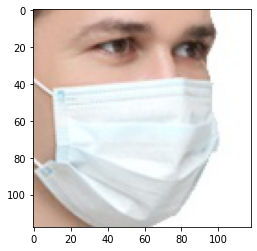

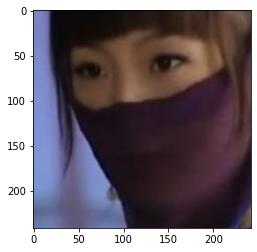

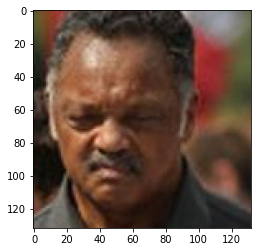

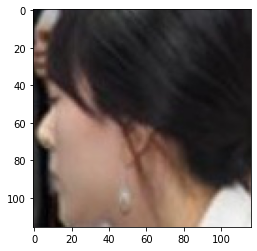

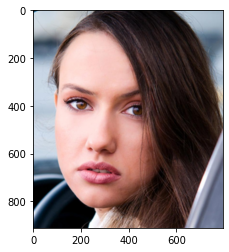

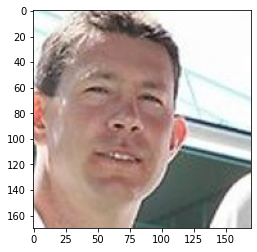

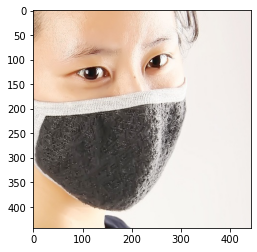

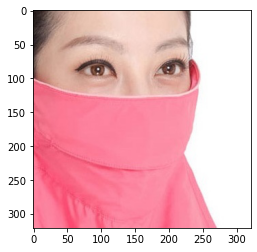

In [29]:
import os 
i = 0
for image in os.listdir('/StudentData/train/'):
    if i>50: 
        break
    img = mpimg.imread('/StudentData/train/'+image)
    plt.figure()
    plt.imshow(img)
    i+=1

In [3]:
shapes_0 = []
shapes_1 = []

for image in os.listdir('/StudentData/train/'):
    img = mpimg.imread('/StudentData/train/'+image)
    shapes_0.append(img.shape[0])
    shapes_1.append(img.shape[1])


In [4]:
import statistics
print(statistics.median(shapes_0))
print(statistics.median(shapes_1))

127
127


In [3]:
import os 
with_mask = 0
without_mask = 0
for image in os.listdir('/StudentData/train/'):
    if image[-5]=='0':
        without_mask+=1
    else:
        with_mask+=1

In [4]:
with_mask

9948

In [5]:
without_mask

8311

In [6]:
trainset_size = with_mask+without_mask

In [7]:
import os 
with_mask = 0
without_mask = 0
for image in os.listdir('/StudentData/test/'):
    if image[-5]=='0':
        without_mask+=1
    else:
        with_mask+=1

In [8]:
testset_size = with_mask+without_mask

Put in image directory with sub-directory for each label

In [20]:
import os
from shutil import copyfile

for image in os.listdir('/StudentData/train/'):
    if image[-5]=='0':
        copyfile('/StudentData/train/'+image, '/StudentData/train_sorted/0/'+image)
    else:
        copyfile('/StudentData/train/'+image, '/StudentData/train_sorted/1/'+image)

In [21]:
for image in os.listdir('/StudentData/test/'):
    if image[-5]=='0':
        copyfile('/StudentData/test/'+image, '/StudentData/test_sorted/0/'+image)
    else:
        copyfile('/StudentData/test/'+image, '/StudentData/test_sorted/1/'+image)

Experiments

In [9]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [10]:
batch_size = 64

In [11]:
def load_dataset(data_path,transform):
    dataset = torchvision.datasets.ImageFolder(root=data_path,transform=transform)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return loader


In [12]:
nimages = 0
mean = 0.
std = 0.
for batch, _ in load_dataset("/StudentData/train_sorted/",transform):
    batch = batch.view(batch.size(0), batch.size(1), -1)
    nimages += batch.size(0)
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)

# Final step
mean /= nimages
std /= nimages

In [13]:
mean

tensor([0.5227, 0.4494, 0.4206])

In [14]:
std

tensor([0.2383, 0.2270, 0.2233])

In [12]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.ColorJitter(brightness=0.5),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomApply([transforms.RandomRotation([-30, 30])], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5227, 0.4495, 0.4206], std=[0.2383, 0.2270, 0.2233])
])

In [13]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5227, 0.4495, 0.4206], std=[0.2383, 0.2270, 0.2233])
])

In [14]:
num_epochs = 30

learning_rate = 0.001

In [15]:
def to_gpu(x):
    return x.cuda() if torch.cuda.is_available() else x

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fc = nn.Linear(8192, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)  

        return self.sigmoid(out)

In [17]:
cnn = CNN()
cnn = to_gpu(cnn) 
# convert all the weights tensors to cuda()
# Loss and Optimizer

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

print('number of parameters: ', sum(param.numel() for param in cnn.parameters()))
print(f'Num of trainable parameters : {sum(p.numel() for p in cnn.parameters() if p.requires_grad)}')

number of parameters:  48033
Num of trainable parameters : 48033


In [18]:
train_loader = load_dataset("/StudentData/train_sorted/",train_transform)

In [19]:
test_loader = load_dataset("/StudentData/test_sorted/",test_transform)

In [20]:
import time
def get_train_loss_f1():
    cnn.eval() 
    correct = 0
    total = 0
    TP = 0
    FP = 0
    FN = 0
    accumulated_loss = 0
    for images, labels in load_dataset("/StudentData/train_sorted/",test_transform):
        images = to_gpu(images)
        outputs = cnn(images)
        current_batch_size = len(labels)
        #labels = to_gpu(labels)
        #labels = labels.float()
        accumulated_loss += ((criterion(outputs.cpu(), labels.float())).item())*current_batch_size
        predicted = torch.round(outputs).view(-1)
        list_predictions = list(predicted.cpu())
        list_labels = list(labels)
        TP += sum([1 for label,prediction in zip(list_labels,list_predictions) if label==1 and prediction==1])
        FP += sum([1 for label,prediction in zip(list_labels,list_predictions) if label==0 and prediction==1])
        FN += sum([1 for label,prediction in zip(list_labels,list_predictions) if label==1 and prediction==0])
        total += current_batch_size
        correct += (predicted.cpu() == labels).sum()

    average_loss = accumulated_loss/trainset_size
    f1 = 2*TP/(2*TP+FP+FN)
    print('Train Accuracy : %f %%' % (100 * correct / float(total)))
    print('Train F1 : %f %%' % (100 * 2*TP/(2*TP+FP+FN)))
    print('Train average loss : %f' % (average_loss))
    return average_loss,f1

In [21]:
def get_test_loss_f1():
    cnn.eval() 
    correct = 0
    total = 0
    TP = 0
    FP = 0
    FN = 0
    accumulated_loss = 0
    for images, labels in test_loader:
        images = to_gpu(images)
        outputs = cnn(images)
        current_batch_size = len(labels)
        accumulated_loss += ((criterion(outputs.cpu(), labels.float())).item())*current_batch_size
        predicted = torch.round(outputs).view(-1)
        total += current_batch_size
        list_predictions = list(predicted.cpu())
        list_labels = list(labels)
        TP += sum([1 for label,prediction in zip(list_labels,list_predictions) if label==1 and prediction==1])
        FP += sum([1 for label,prediction in zip(list_labels,list_predictions) if label==0 and prediction==1])
        FN += sum([1 for label,prediction in zip(list_labels,list_predictions) if label==1 and prediction==0])
        correct += (predicted.cpu() == labels).sum()
    average_loss = accumulated_loss/testset_size
    f1 = 2*TP/(2*TP+FP+FN)
    print('Test Accuracy : %f %%' % (100 * correct / float(total)))
    print('Test F1 : %f %%' % (100 * 2*TP/(2*TP+FP+FN)))
    print('Test average loss : %f' % (average_loss))
    return average_loss,f1

In [22]:

train_loss_list = []
train_f1_list = []
test_loss_list = []
test_f1_list = []
best_f1 = 0
for epoch in range(num_epochs):
    cnn.train()
    for i, (images, labels) in enumerate(train_loader):
        
        images = to_gpu(images)
        labels = to_gpu(labels)
        labels = labels.float()
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1,
                     (trainset_size)//batch_size, loss.item()))
    train_loss, train_f1 = get_train_loss_f1()
    test_loss, test_f1 = get_test_loss_f1()
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_f1_list.append(train_f1)
    test_f1_list.append(test_f1)
    if test_f1>best_f1:
        best_f1 = test_f1
        torch.save(cnn.state_dict(), 'model')

/home/student/.conda/envs/hw2_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [1/30], Iter [100/285] Loss: 0.2760
Epoch [1/30], Iter [200/285] Loss: 0.1963


/home/student/.conda/envs/hw2_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Train Accuracy : 94.682076 %
Train F1 : 95.232952 %
Train average loss : 0.156963


/home/student/.conda/envs/hw2_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Test Accuracy : 95.004929 %
Test F1 : 95.485595 %
Test average loss : 0.157257
Epoch [2/30], Iter [100/285] Loss: 0.2178
Epoch [2/30], Iter [200/285] Loss: 0.2000
Train Accuracy : 95.405006 %
Train F1 : 95.819006 %
Train average loss : 0.124832
Test Accuracy : 95.448570 %
Test F1 : 95.817605 %
Test average loss : 0.134593
Epoch [3/30], Iter [100/285] Loss: 0.2850
Epoch [3/30], Iter [200/285] Loss: 0.1190
Train Accuracy : 95.755516 %
Train F1 : 96.065391 %
Train average loss : 0.123364
Test Accuracy : 95.415710 %
Test F1 : 95.710992 %
Test average loss : 0.138730
Epoch [4/30], Iter [100/285] Loss: 0.4107
Epoch [4/30], Iter [200/285] Loss: 0.1849
Train Accuracy : 96.067696 %
Train F1 : 96.452920 %
Train average loss : 0.113285
Test Accuracy : 95.744331 %
Test F1 : 96.130285 %
Test average loss : 0.128729
Epoch [5/30], Iter [100/285] Loss: 0.2249
Epoch [5/30], Iter [200/285] Loss: 0.1131
Train Accuracy : 96.292236 %
Train F1 : 96.585464 %
Train average loss : 0.103068
Test Accuracy : 95.7

In [23]:
best_f1

0.9771062271062271

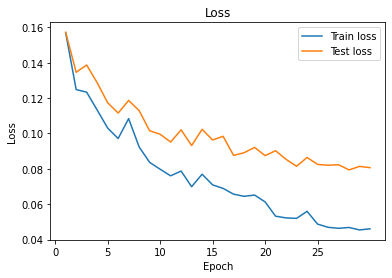

In [24]:
import matplotlib.pyplot as plt
plt.plot([i+1 for i in range(num_epochs)],train_loss_list,label='Train loss')
plt.plot([i+1 for i in range(num_epochs)],test_loss_list,label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.xticks(range(0,num_epochs,5))
plt.legend()

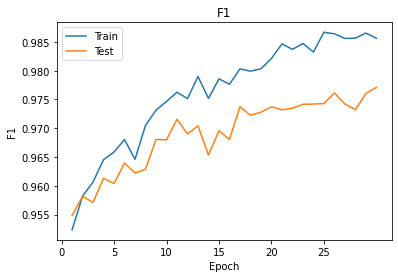

In [25]:
plt.plot([i+1 for i in range(num_epochs)],train_f1_list,label='Train')
plt.plot([i+1 for i in range(num_epochs)],test_f1_list,label='Test')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('F1')
plt.xticks(range(0,num_epochs,5))
plt.legend()

In [26]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import numpy as np
cnn.eval()
def create_recall_precision_curves():
    with torch.no_grad():
        probabilities_list = []
        labels_list = []
        for images, labels in load_dataset("/StudentData/train_sorted/",test_transform):
            images = to_gpu(images)
            outputs = cnn(images)
            current_batch_size = len(labels)
            batch_list = list(outputs.cpu())
            probabilities_list = probabilities_list + batch_list
            labels_list = labels_list + list(labels)
        fpr_train, tpr_train, _ = roc_curve(np.array(labels_list), np.array(probabilities_list))
        roc_auc_train = auc(fpr_train, tpr_train)
        probabilities_list = []
        labels_list = []
        for images, labels in test_loader:
            images = to_gpu(images)
            outputs = cnn(images)
            current_batch_size = len(labels)
            batch_list = list(outputs.cpu())
            probabilities_list = probabilities_list + batch_list
            labels_list = labels_list + list(labels)
        fpr_test, tpr_test, _ = roc_curve(np.array(labels_list), np.array(probabilities_list))
        roc_auc_test = auc(fpr_test, tpr_test)
        plt.plot(fpr_train, tpr_train, label='ROC curve train (area = %0.3f)' % roc_auc_train)
        plt.plot(fpr_test, tpr_test, label='ROC curve test (area = %0.3f)' % roc_auc_test)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate or (1 - Specifity)')
        plt.ylabel('True Positive Rate or (Sensitivity)')
        plt.title('ROC')
        plt.legend(loc="lower right")

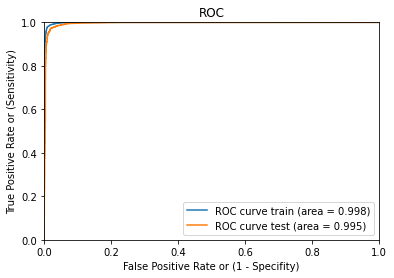

In [27]:
create_recall_precision_curves()

In [75]:
torch.save(cnn.state_dict(), 'model')

FP


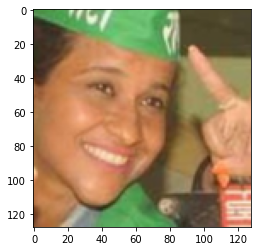

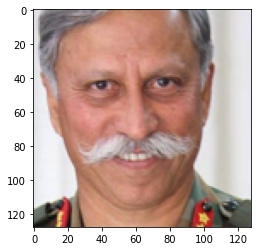

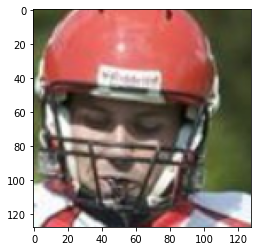

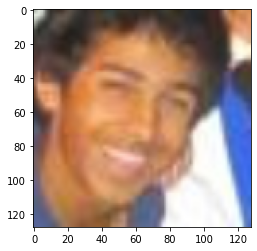

FN


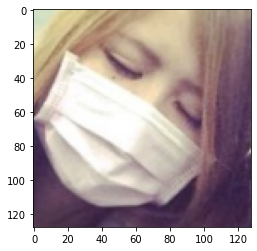

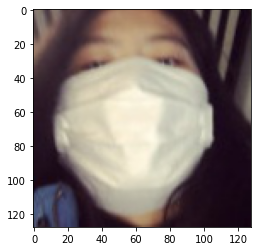

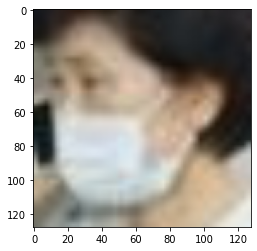

FP
FN


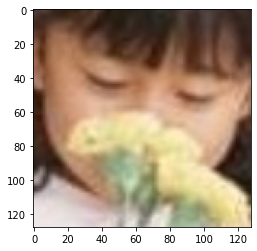

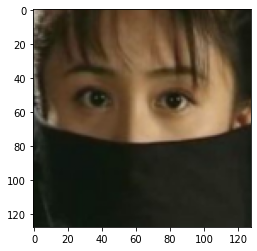

FP


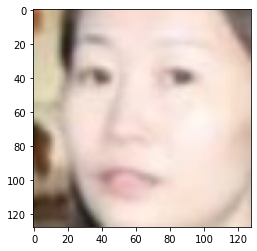

FN


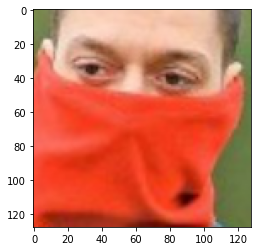

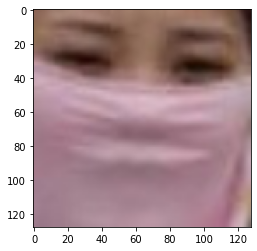

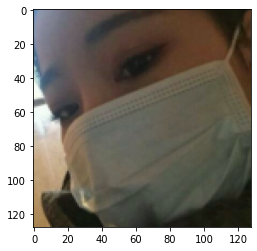

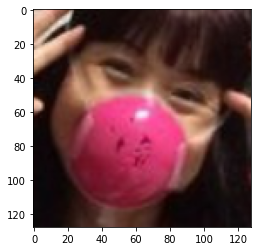

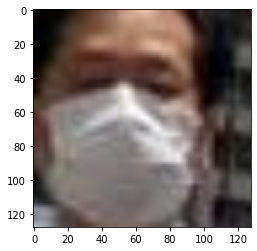

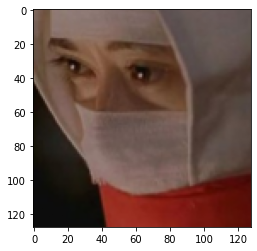

FP


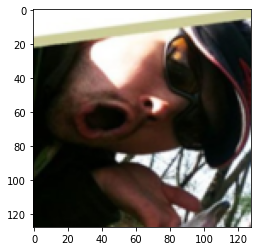

FN


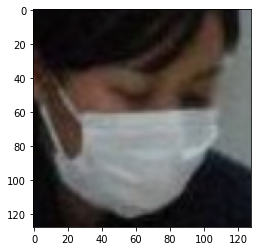

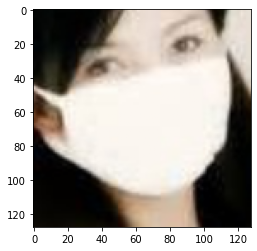

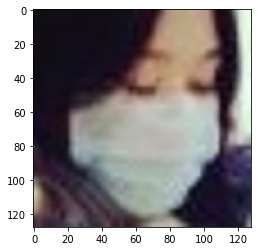

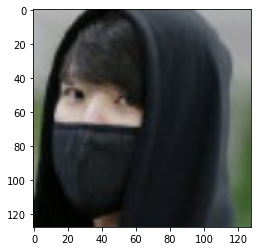

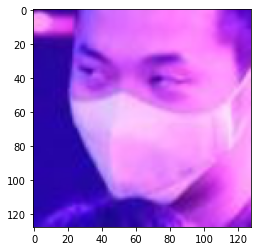

In [30]:
count=0
for images, labels in load_dataset("/StudentData/test_sorted/",transform):
    count+=1
    gpu_images = to_gpu(images)
    outputs = cnn(gpu_images)
    predicted = torch.round(outputs).view(-1)
    list_predictions = list(predicted.cpu())
    list_labels = list(labels)
    FP_index = [i for i,(prediction,label) in enumerate(zip(list_predictions,list_labels)) if prediction==1 and label==0] 
    FN_index = [i for i,(prediction,label) in enumerate(zip(list_predictions,list_labels)) if prediction==0 and label==1]
    print('FP')
    for i in FP_index:
        plt.figure()
        plt.imshow(images[i].permute(1, 2, 0))
        plt.show()
    print('FN')
    for i in FN_index:
        plt.figure()
        plt.imshow(images[i].permute(1, 2, 0))
        plt.show()
    if count>3:
        break

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor()
])
count=0
for images, labels in load_dataset("/StudentData/test_sorted/",transform):
    count+=1
    
    for i in range(batch_size):
        plt.figure()
        plt.imshow(images[i].permute(1, 2, 0))
        plt.show()

    if count>3:
        break